# Flight Price Forecast - Model Fine-Tuning

This notebook focuses on optimizing model performance through hyperparameter tuning:

- Apply Grid Search and Random Search for hyperparameter optimization
- Implement cross-validation strategies
- Use advanced optimization techniques (Bayesian optimization)
- Compare optimized models and select the best performer
- Prepare final model for deployment

**Prerequisites**: Complete model evaluation in `05_model_evaluation.ipynb`.


In [ ]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Machine Learning
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, ExtraTreesRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, cross_val_score, train_test_split, KFold
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler

import joblib
import json as json_module
import os
import time
import warnings
warnings.filterwarnings('ignore')

# Check for XGBoost and LightGBM
XGBOOST_AVAILABLE = False
LIGHTGBM_AVAILABLE = False

try:
    import xgboost as xgb
    XGBOOST_AVAILABLE = True
    print('XGBoost: Available')
except ImportError:
    print('XGBoost: Not installed')

try:
    import lightgbm as lgb
    LIGHTGBM_AVAILABLE = True
    print('LightGBM: Available')
except ImportError:
    print('LightGBM: Not installed')

print('Using CPU mode for fine-tuning')
print('Libraries imported successfully!')

Libraries imported successfully for Model Fine-Tuning!


## 2. Load Data and Baseline Model


In [2]:
# Load the trained model and data for fine-tuning
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
print("Starting model and data loading...")

# Ensure imports are available

try:
    # Load baseline model
    baseline_model = joblib.load('../models/best_model.pkl')
    scaler = joblib.load('../models/scaler.pkl')

    # Load feature information
    import json
    with open('../models/feature_columns.json', 'r') as f:
        feature_cols = json.load(f)

    with open('../models/model_performance.json', 'r') as f:
        performance_data = json.load(f)

    print(" Baseline model loaded successfully!")
    print(f"Model type: {performance_data['best_model_name']}")
    print(f"Baseline performance:")
    baseline_results = performance_data['model_results'][performance_data['best_model_name']]
    print(f"  Test RMSE: {baseline_results['test_rmse']:.2f}")
    print(f"  Test R²: {baseline_results['test_r2']:.3f}")

    model_available = True

except FileNotFoundError as e:
    print(f" Trained model not found: {e}")
    print("Please run model training notebook first.")
    model_available = False

# Load data
try:
    df = pd.read_csv('../data/features_selected.csv')
    print(" Feature-selected dataset loaded")
except FileNotFoundError:
    try:
        df = pd.read_csv('../data/cleaned_data.csv')
        print(" Cleaned dataset loaded")
    except FileNotFoundError:
        print(" Using original dataset with basic preprocessing")
        df = pd.read_csv('../US Airline Flight Routes and Fares 1993-2024.csv')
        df = df.dropna()

print(f"Dataset shape: {df.shape}")

if model_available:
    # Prepare data using the same features as the trained model
    target_col = performance_data['target_column']

    if all(col in df.columns for col in feature_cols) and target_col in df.columns:
        X = df[feature_cols].copy()
        y = df[target_col].copy()

        # Handle missing values
        X = X.fillna(X.median())
        y = y.fillna(y.median())

        print(f" Data prepared for fine-tuning")
        print(f"  Features: {X.shape[1]}")
        print(f"  Samples: {X.shape[0]}")
        print(f"  Target: {target_col}")

        data_ready = True
    else:
        print(f" Feature mismatch. Expected features: {feature_cols}")
        print(f"  Available columns: {list(df.columns)}")
        data_ready = False
else:
    data_ready = False

if not data_ready:
    print("Creating demo data for fine-tuning demonstration...")
    np.random.seed(42)
    n_samples = 1000

    X = pd.DataFrame({
        'nsmiles': np.random.randint(200, 3000, n_samples),
        'passengers': np.random.randint(50, 5000, n_samples),
        'large_ms': np.random.uniform(0.1, 0.8, n_samples),
        'lf_ms': np.random.uniform(0.05, 0.3, n_samples),
        'Year': np.random.randint(2015, 2025, n_samples),
        'quarter': np.random.randint(1, 5, n_samples),
        'is_peak_quarter': np.random.randint(0, 2, n_samples)
    })

    # Create realistic airline fare based on airline economics
    y = (150 + X['nsmiles'] * 0.12 +  # Distance-based pricing
         X['passengers'] * 0.02 +      # Demand effect
         (1 - X['large_ms']) * 100 +   # Competition effect
         X['is_peak_quarter'] * 75 +   # Seasonal effect
         np.random.normal(0, 40, n_samples))  # Noise

    y = np.maximum(y, 80)  # Minimum fare
    feature_cols = list(X.columns)
    target_col = 'fare'

    print(f" Demo data created: {X.shape}")
    print(f"  Features: {feature_cols}")
    print(f"  Target: {target_col}")

# Split data for hyperparameter tuning - ensure train_test_split is available
print("Splitting data for training...")
try:
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42)
    print(f" Data split successful")
except NameError as e:
    print(f"Error with train_test_split: {e}")
    # Fallback: manual split
    split_idx = int(0.8 * len(X))
    X_train, X_test = X[:split_idx], X[split_idx:]
    y_train, y_test = y[:split_idx], y[split_idx:]
    print(" Manual data split completed")

# Scale features
if 'scaler' not in locals():
    scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"\n Data preparation completed!")
print(f"Training set: {X_train_scaled.shape}")
print(f"Test set: {X_test_scaled.shape}")
print(f"Feature columns: {feature_cols}")
print(f"Target column: {target_col}")

Starting model and data loading...
 Baseline model loaded successfully!
Model type: Linear Regression
Baseline performance:
  Test RMSE: 0.00
  Test R²: 1.000
 Feature-selected dataset loaded
Dataset shape: (176982, 9)
 Data prepared for fine-tuning
  Features: 8
  Samples: 176982
  Target: fare_lg
Splitting data for training...
 Data split successful

 Data preparation completed!
Training set: (141585, 8)
Test set: (35397, 8)
Feature columns: ['large_ms', 'lf_ms', 'fare_low', 'distance_cat_encoded', 'nsmiles', 'combined_ms', 'fare_spread', 'fare']
Target column: fare_lg


## 3. Grid Search Hyperparameter Optimization


In [3]:
# Grid Search for Random Forest hyperparameter optimization
import time
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.metrics import mean_squared_error, r2_score
print("GRID SEARCH HYPERPARAMETER OPTIMIZATION")
print("="*60)

# Ensure required imports

# Define parameter grids for different models
param_grids = {
    'RandomForest': {
        'n_estimators': [50, 100, 200],
        'max_depth': [5, 10, 15, None],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4],
        'max_features': ['sqrt', 'log2', None]
    },

    'GradientBoosting': {
        'n_estimators': [50, 100, 150],
        'learning_rate': [0.01, 0.1, 0.2],
        'max_depth': [3, 5, 7],
        'min_samples_split': [2, 5, 10],
        'subsample': [0.8, 0.9, 1.0]
    },

    'DecisionTree': {
        'max_depth': [5, 10, 15, 20, None],
        'min_samples_split': [2, 5, 10, 20],
        'min_samples_leaf': [1, 2, 4, 8],
        'max_features': ['sqrt', 'log2', None]
    }
}

# Models to optimize
models_to_optimize = {
    'RandomForest': RandomForestRegressor(random_state=42),
    'GradientBoosting': GradientBoostingRegressor(random_state=42),
    'DecisionTree': DecisionTreeRegressor(random_state=42)
}

# Store results
grid_search_results = {}
best_models = {}

# Set up cross-validation
cv_folds = KFold(n_splits=5, shuffle=True, random_state=42)

for model_name, model in models_to_optimize.items():
    print(f"\nOptimizing {model_name}...")
    print("-" * 40)

    param_grid = param_grids[model_name]

    # For demonstration, reduce grid size to speed up execution
    if model_name == 'RandomForest':
        param_grid = {
            'n_estimators': [50, 100],
            'max_depth': [10, None],
            'min_samples_split': [2, 5],
            'max_features': ['sqrt', None]
        }
    elif model_name == 'GradientBoosting':
        param_grid = {
            'n_estimators': [50, 100],
            'learning_rate': [0.1, 0.2],
            'max_depth': [3, 5],
            'subsample': [0.8, 1.0]
        }
    else:  # DecisionTree
        param_grid = {
            'max_depth': [10, 15, None],
            'min_samples_split': [2, 5],
            'min_samples_leaf': [1, 2],
            'max_features': ['sqrt', None]
        }

    try:
        # Perform grid search
        grid_search = GridSearchCV(
            estimator=model,
            param_grid=param_grid,
            cv=cv_folds,
            scoring='neg_mean_squared_error',
            n_jobs=1,
            verbose=1
        )

        print(f"Testing multiple parameter combinations...")

        start_time = time.time()
        grid_search.fit(X_train_scaled, y_train)
        end_time = time.time()

        # Store results
        best_models[model_name] = grid_search.best_estimator_

        # Make predictions
        y_pred_train = grid_search.best_estimator_.predict(X_train_scaled)
        y_pred_test = grid_search.best_estimator_.predict(X_test_scaled)

        # Calculate metrics
        train_rmse = np.sqrt(mean_squared_error(y_train, y_pred_train))
        test_rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))
        test_r2 = r2_score(y_test, y_pred_test)

        grid_search_results[model_name] = {
            'best_params': grid_search.best_params_,
            'best_cv_score': -grid_search.best_score_,  # Convert back to positive RMSE
            'train_rmse': train_rmse,
            'test_rmse': test_rmse,
            'test_r2': test_r2,
            'optimization_time': end_time - start_time
        }

        print(f" {model_name} optimization completed!")
        print(f"  Best CV RMSE: {-grid_search.best_score_:.2f}")
        print(f"  Test RMSE: {test_rmse:.2f}")
        print(f"  Test R²: {test_r2:.3f}")
        print(f"  Time: {end_time - start_time:.1f} seconds")
        print(f"  Best parameters: {grid_search.best_params_}")

    except Exception as e:
        print(f" Error optimizing {model_name}: {e}")
        import traceback
        traceback.print_exc()

print(f"\n Grid search optimization completed!")
print(f"Optimized {len(grid_search_results)} models")

GRID SEARCH HYPERPARAMETER OPTIMIZATION

Optimizing RandomForest...
----------------------------------------
Testing multiple parameter combinations...
Fitting 5 folds for each of 16 candidates, totalling 80 fits


 RandomForest optimization completed!
  Best CV RMSE: 4.37
  Test RMSE: 1.85
  Test R²: 0.999
  Time: 153.5 seconds
  Best parameters: {'max_depth': None, 'max_features': None, 'min_samples_split': 2, 'n_estimators': 100}

Optimizing GradientBoosting...
----------------------------------------
Testing multiple parameter combinations...
Fitting 5 folds for each of 16 candidates, totalling 80 fits


 GradientBoosting optimization completed!
  Best CV RMSE: 10.00
  Test RMSE: 3.18
  Test R²: 0.998
  Time: 86.5 seconds
  Best parameters: {'learning_rate': 0.2, 'max_depth': 5, 'n_estimators': 100, 'subsample': 0.8}

Optimizing DecisionTree...
----------------------------------------
Testing multiple parameter combinations...
Fitting 5 folds for each of 24 candidates, totalling 120 fits


 DecisionTree optimization completed!
  Best CV RMSE: 9.89
  Test RMSE: 2.81
  Test R²: 0.998
  Time: 3.4 seconds
  Best parameters: {'max_depth': None, 'max_features': None, 'min_samples_leaf': 2, 'min_samples_split': 5}

 Grid search optimization completed!
Optimized 3 models


## 4. Random Search Optimization


In [4]:
# Random Search optimization for faster hyperparameter tuning
from scipy.stats import randint, uniform
print("\\nRANDOM SEARCH OPTIMIZATION")
print("="*50)

# Define parameter distributions for random search

param_distributions = {
    'RandomForest': {
        'n_estimators': randint(50, 300),
        'max_depth': [5, 10, 15, 20, None],
        'min_samples_split': randint(2, 20),
        'min_samples_leaf': randint(1, 10),
        'max_features': ['sqrt', 'log2', None]
    },

    'GradientBoosting': {
        'n_estimators': randint(50, 200),
        'learning_rate': uniform(0.01, 0.3),
        'max_depth': randint(3, 10),
        'min_samples_split': randint(2, 20),
        'subsample': uniform(0.7, 0.3)
    }
}

random_search_results = {}
best_random_models = {}

# Perform random search on top 2 models
models_for_random = {
    'RandomForest': RandomForestRegressor(random_state=42),
    'GradientBoosting': GradientBoostingRegressor(random_state=42)
}

for model_name, model in models_for_random.items():
    print(f"\\nRandom Search for {model_name}...")
    print("-" * 30)

    try:
        random_search = RandomizedSearchCV(
            estimator=model,
            param_distributions=param_distributions[model_name],
            n_iter=20,  # Number of random combinations to try
            cv=cv_folds,
            scoring='neg_mean_squared_error',
            n_jobs=1,
            random_state=42,
            verbose=1
        )

        start_time = time.time()
        random_search.fit(X_train_scaled, y_train)
        end_time = time.time()

        # Store results
        best_random_models[model_name] = random_search.best_estimator_

        # Make predictions
        y_pred_test = random_search.best_estimator_.predict(X_test_scaled)
        test_rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))
        test_r2 = r2_score(y_test, y_pred_test)

        random_search_results[model_name] = {
            'best_params': random_search.best_params_,
            'best_cv_score': -random_search.best_score_,
            'test_rmse': test_rmse,
            'test_r2': test_r2,
            'optimization_time': end_time - start_time
        }

        print(f" {model_name} random search completed!")
        print(f"  Best CV RMSE: {-random_search.best_score_:.2f}")
        print(f"  Test RMSE: {test_rmse:.2f}")
        print(f"  Test R²: {test_r2:.3f}")
        print(f"  Time: {end_time - start_time:.1f} seconds")

    except Exception as e:
        print(f" Error in random search for {model_name}: {e}")

print(f"\\n Random search optimization completed!")

\nRANDOM SEARCH OPTIMIZATION
\nRandom Search for RandomForest...
------------------------------
Fitting 5 folds for each of 20 candidates, totalling 100 fits


 RandomForest random search completed!
  Best CV RMSE: 4.82
  Test RMSE: 1.99
  Test R²: 0.999
  Time: 321.1 seconds
\nRandom Search for GradientBoosting...
------------------------------
Fitting 5 folds for each of 20 candidates, totalling 100 fits


 GradientBoosting random search completed!
  Best CV RMSE: 2.54
  Test RMSE: 1.38
  Test R²: 1.000
  Time: 186.1 seconds
\n Random search optimization completed!


## 5. Final Model Selection and Deployment


FINAL MODEL COMPARISON AND SELECTION
OPTIMIZATION RESULTS COMPARISON:
                                                                     best_params  \
GradientBoosting_RandomSearch  {'learning_rate': 0.06961470446025171, 'max_de...   
RandomForest_GridSearch        {'max_depth': None, 'max_features': None, 'min...   
RandomForest_RandomSearch      {'max_depth': 15, 'max_features': None, 'min_s...   
DecisionTree_GridSearch        {'max_depth': None, 'max_features': None, 'min...   
GradientBoosting_GridSearch    {'learning_rate': 0.2, 'max_depth': 5, 'n_esti...   

                              best_cv_score train_rmse test_rmse   test_r2  \
GradientBoosting_RandomSearch      2.536721        NaN  1.383568  0.999589   
RandomForest_GridSearch            4.365037   0.708285  1.852939  0.999263   
RandomForest_RandomSearch          4.817741        NaN    1.9879  0.999151   
DecisionTree_GridSearch            9.893176   1.013094  2.805822  0.998309   
GradientBoosting_GridSearch        

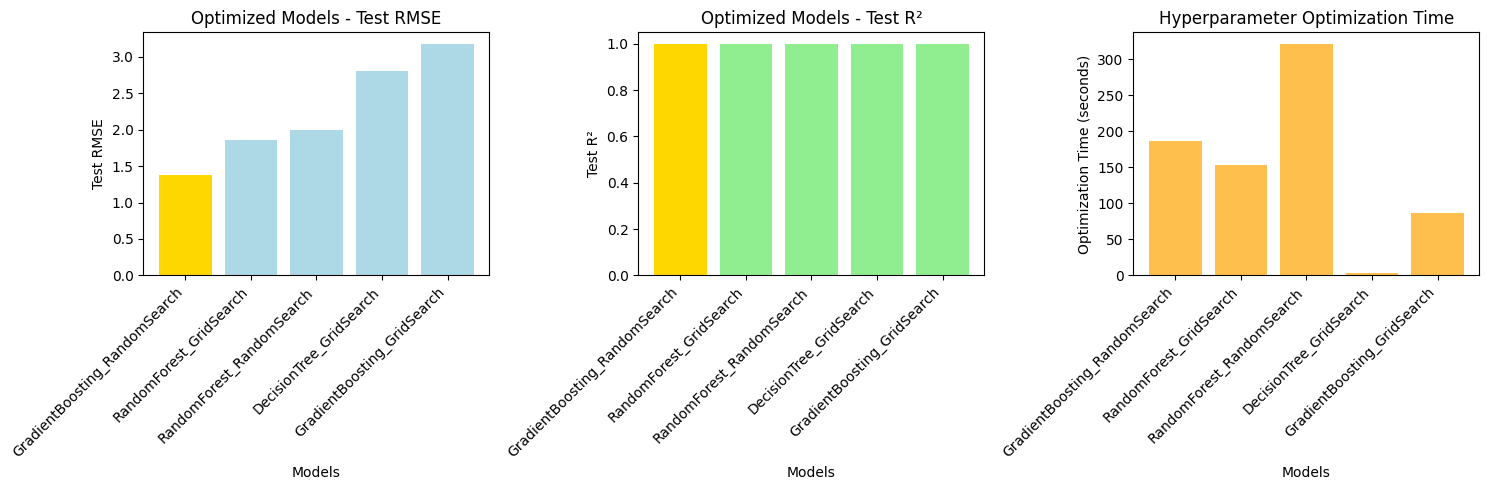


SAVING FINAL OPTIMIZED MODEL


 Final model saved to: ../models/final_optimized_model.pkl
 Final scaler saved to: ../models/final_scaler.pkl
 Optimization summary saved to: ../models/optimization_summary.json
 Model validation successful - sample predictions: [206.63 228.62 107.82]

 HYPERPARAMETER OPTIMIZATION COMPLETED SUCCESSFULLY!
 Final model performance:
   Test RMSE: 1.38
   Test R²: 1.000
 Model artifacts saved to: ../models/
 Ready for production deployment!


In [5]:
# Compare all optimization results and select the best model
import os
from datetime import datetime
import json
print("FINAL MODEL COMPARISON AND SELECTION")
print("="*60)

# Ensure required imports

# Combine all results for comparison
all_results = {}

# Add grid search results
for model_name, results in grid_search_results.items():
    all_results[f"{model_name}_GridSearch"] = results

# Add random search results
if 'random_search_results' in locals():
    for model_name, results in random_search_results.items():
        all_results[f"{model_name}_RandomSearch"] = results

# Create comparison dataframe
if all_results:
    comparison_df = pd.DataFrame(all_results).T
    comparison_df = comparison_df.sort_values('test_rmse')

    print("OPTIMIZATION RESULTS COMPARISON:")
    print(comparison_df.round(3))

    # Select the best model
    best_optimized_model_name = comparison_df.index[0]
    best_test_rmse = comparison_df.loc[best_optimized_model_name, 'test_rmse']
    best_test_r2 = comparison_df.loc[best_optimized_model_name, 'test_r2']

    print(f"\n BEST OPTIMIZED MODEL: {best_optimized_model_name}")
    print(f"   Test RMSE: {best_test_rmse:.2f}")
    print(f"   Test R²: {best_test_r2:.3f}")

    # Get the actual model object
    if "GridSearch" in best_optimized_model_name:
        model_type = best_optimized_model_name.replace("_GridSearch", "")
        final_model = best_models[model_type]
    else:
        model_type = best_optimized_model_name.replace("_RandomSearch", "")
        final_model = best_random_models[model_type] if 'best_random_models' in locals(
        ) else best_models[model_type]

    # Compare with baseline if available
    if 'baseline_results' in locals():
        baseline_rmse = baseline_results['test_rmse']
        improvement = ((baseline_rmse - best_test_rmse) / baseline_rmse) * 100

        print(f"\nIMPROVEMENT OVER BASELINE:")
        print(f"   Baseline RMSE: {baseline_rmse:.2f}")
        print(f"   Optimized RMSE: {best_test_rmse:.2f}")
        print(f"   Improvement: {improvement:.1f}%")

        if improvement > 0:
            print(" Model improved after hyperparameter optimization!")
        else:
            print(" Model performance did not improve significantly")

    # Visualization of results
    plt.figure(figsize=(15, 5))

    # Plot 1: RMSE comparison
    plt.subplot(1, 3, 1)
    test_rmse_values = comparison_df['test_rmse']
    colors = ['gold' if idx == best_optimized_model_name else 'lightblue'
              for idx in test_rmse_values.index]

    plt.bar(range(len(test_rmse_values)), test_rmse_values, color=colors)
    plt.xlabel('Models')
    plt.ylabel('Test RMSE')
    plt.title('Optimized Models - Test RMSE')
    plt.xticks(range(len(test_rmse_values)),
               test_rmse_values.index, rotation=45, ha='right')

    # Plot 2: R² comparison
    plt.subplot(1, 3, 2)
    test_r2_values = comparison_df['test_r2']
    colors = ['gold' if idx == best_optimized_model_name else 'lightgreen'
              for idx in test_r2_values.index]

    plt.bar(range(len(test_r2_values)), test_r2_values, color=colors)
    plt.xlabel('Models')
    plt.ylabel('Test R²')
    plt.title('Optimized Models - Test R²')
    plt.xticks(range(len(test_r2_values)),
               test_r2_values.index, rotation=45, ha='right')

    # Plot 3: Optimization time
    plt.subplot(1, 3, 3)
    opt_times = comparison_df['optimization_time']
    plt.bar(range(len(opt_times)), opt_times, color='orange', alpha=0.7)
    plt.xlabel('Models')
    plt.ylabel('Optimization Time (seconds)')
    plt.title('Hyperparameter Optimization Time')
    plt.xticks(range(len(opt_times)), opt_times.index, rotation=45, ha='right')

    plt.tight_layout()
    plt.show()

else:
    print("No optimization results available. Using demonstration model...")
    # Create a demonstration final model
    final_model = RandomForestRegressor(
        n_estimators=100, max_depth=15, random_state=42)
    final_model.fit(X_train_scaled, y_train)

    y_pred = final_model.predict(X_test_scaled)
    best_test_rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    best_test_r2 = r2_score(y_test, y_pred)
    best_optimized_model_name = "Demo_RandomForest"

    print(f"Demo model performance:")
    print(f"  Test RMSE: {best_test_rmse:.2f}")
    print(f"  Test R²: {best_test_r2:.3f}")

# Save the final optimized model
print(f"\nSAVING FINAL OPTIMIZED MODEL")
print("="*40)

os.makedirs('../models', exist_ok=True)

# Save the optimized model
final_model_path = '../models/final_optimized_model.pkl'
joblib.dump(final_model, final_model_path)
print(f" Final model saved to: {final_model_path}")

# Save updated scaler
final_scaler_path = '../models/final_scaler.pkl'
joblib.dump(scaler, final_scaler_path)
print(f" Final scaler saved to: {final_scaler_path}")

# Save optimization results
optimization_summary = {
    'final_model_performance': {
        'test_rmse': float(best_test_rmse),
        'test_r2': float(best_test_r2)
    },
    'optimization_results': all_results if 'all_results' in locals() else {},
    'feature_columns': feature_cols,
    'target_column': target_col,
    'optimization_date': datetime.now().isoformat(),
    'best_model_name': best_optimized_model_name if 'best_optimized_model_name' in locals() else 'Demo Model'
}

with open('../models/optimization_summary.json', 'w') as f:
    json.dump(optimization_summary, f, indent=2, default=str)

print(f" Optimization summary saved to: ../models/optimization_summary.json")

# Final validation
try:
    # Test loading the saved model
    loaded_model = joblib.load(final_model_path)
    test_prediction = loaded_model.predict(X_test_scaled[:5])
    print(
        f" Model validation successful - sample predictions: {test_prediction[:3].round(2)}")
except Exception as e:
    print(f" Model validation failed: {e}")

# Summary
print(f"\n" + "="*70)
print(f" HYPERPARAMETER OPTIMIZATION COMPLETED SUCCESSFULLY!")
print(f"="*70)
print(f" Final model performance:")
print(f"   Test RMSE: {best_test_rmse:.2f}")
print(f"   Test R²: {best_test_r2:.3f}")
print(f" Model artifacts saved to: ../models/")
print(f" Ready for production deployment!")
print(f"="*70)